In [47]:
%config InlineBackend.figure_formats = {"retina", "png"}

import os
import tempfile

os.environ["OPENBLAS_NUM_THREADS"] = "1"

from IPython.display import HTML, display
import h5py
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams["figure.figsize"] = (5, 4)

import tdgl
from tdgl.geometry import box, circle
from tdgl.visualization.animate import create_animation

### Superconductive Film

In [48]:
length_units = "nm"
# Material parameters from Petrovic
xi = 13
london_lambda = 39
d = 25
layer = tdgl.Layer(coherence_length=xi, london_lambda=london_lambda, thickness=d, gamma=1)

# Device geometry
total_width = 512
total_length = 512
link_width = total_width / 3
# Outer geometry of the film
# right_notch = (
#     tdgl.Polygon(points=box(total_width))
#     .rotate(45)
#     .translate(dx=(np.sqrt(2) * total_width + link_width) / 2)
# )
# left_notch = right_notch.scale(xfact=-1)
film = (
    tdgl.Polygon("film", points=box(total_width, total_length))
    .resample(401)
    .buffer(0)
)
# Holes in the film
# round_hole = (
#     tdgl.Polygon("round_hole", points=circle(link_width / 2))
#     .translate(dy=total_length / 5)
# )
# square_hole = (
#     tdgl.Polygon("square_hole", points=box(link_width))
#     .rotate(45)
#     .translate(dy=-total_length / 5)
# )
# Current terminals
source = (
    tdgl.Polygon("source", points=box(1.1 * total_width, total_length / 100))
    .translate(dy=total_length / 2)
)
drain = source.scale(yfact=-1).set_name("drain")
#  Voltage measurement points
probe_points = [(0, total_length / 2.5), (0, -total_length / 2.5)]

In [49]:
device = tdgl.Device(
    "small_square", #512x512 nm
    layer=layer,
    film=film,
    terminals=[source,drain],
    probe_points=probe_points,
    length_units=length_units,
)

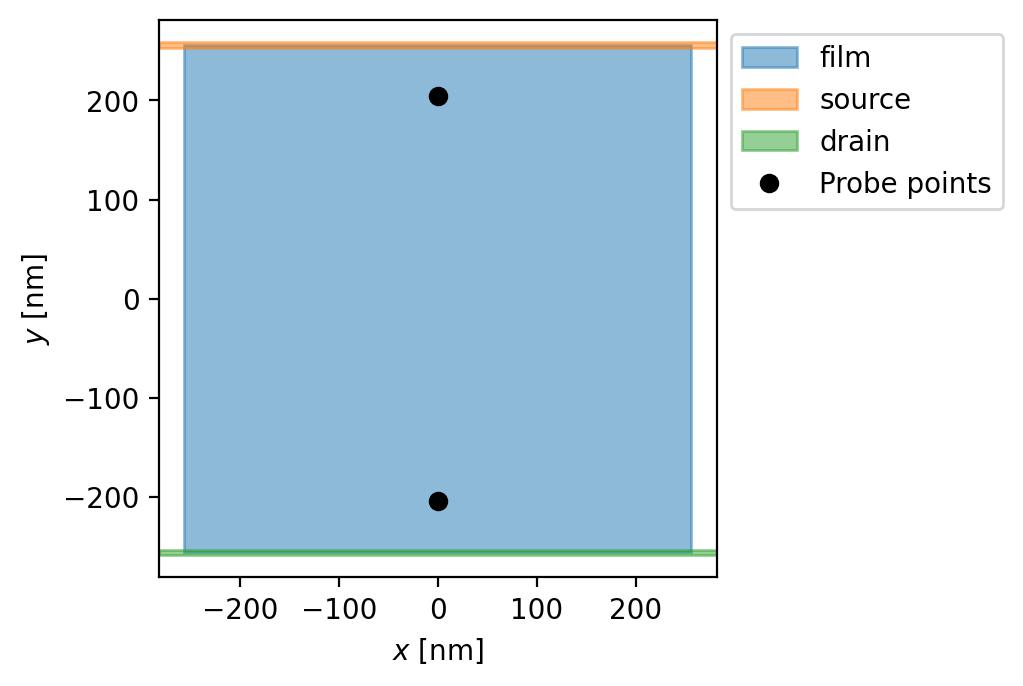

In [50]:
fig, ax = device.draw()

In [51]:
device.make_mesh(max_edge_length=xi / 2, smooth=100)

Constructing Voronoi polygons:   0%|          | 0/21531 [00:00<?, ?it/s]Malformed Voronoi cell surrounding boundary site 1. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 2. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 11. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 12. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a small positive float.
Malformed Voronoi cell surrounding boundary site 14. Try changing the number of boundary mesh sites using Polygon.resample() or Polygon.buffer(eps) where eps is 0 or a sm

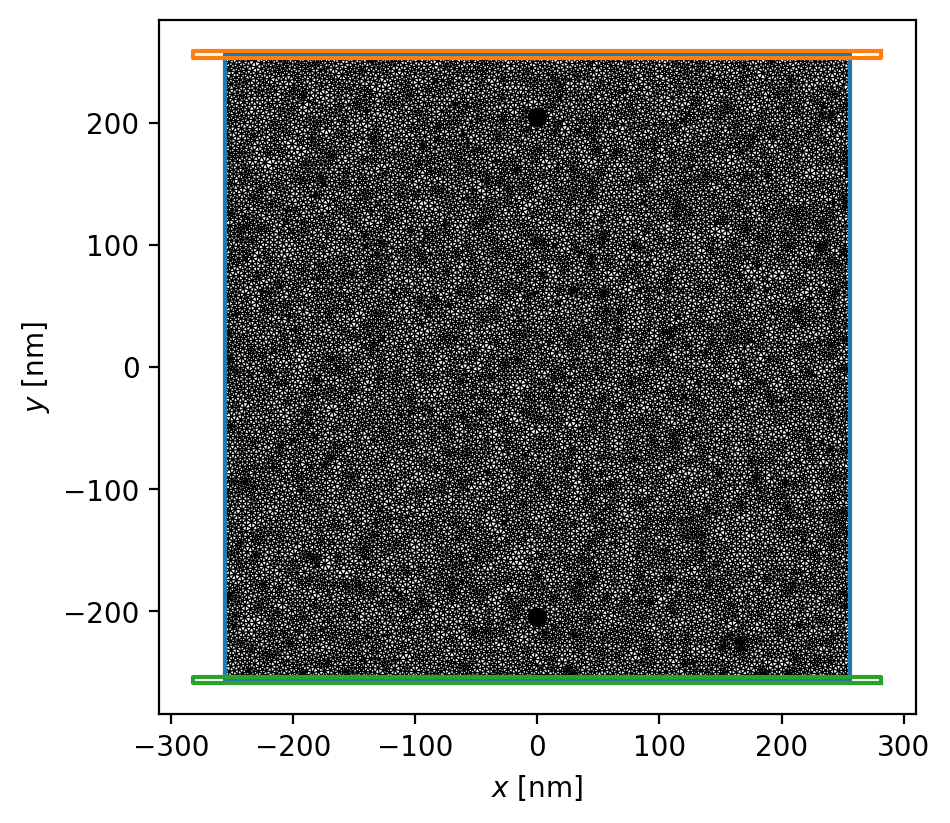

In [52]:
fig, ax = device.plot(mesh=True, legend=False)

In [53]:
device.mesh_stats()

num_sites,21531
num_elements,42602
min_edge_length,1.613e+00
max_edge_length,6.636e+00
mean_edge_length,3.785e+00
min_area,2.277e+00
max_area,2.754e+01
mean_area,1.218e+01
coherence_length,13
length_units,nm


### Simulating with zero field

In [54]:
options = tdgl.SolverOptions(
    # Allow some time to equilibrate before saving data.
    skip_time=100,
    solve_time=150,
    output_file=os.path.join("tdgl_results", "weak-link-zero-field.h5"),
    field_units = "mT",
    current_units="uA",
    save_every=100,
    # gpu=True,
)
# If you do not provide an applied_vector_potential, tdgl defaults to zero applied field.
zero_field_solution = tdgl.solve(
    device,
    options,
    # terminal_currents must satisfy current conservation, i.e.,
    # sum(terminal_currents.values()) == 0.
    terminal_currents=dict(source=120, drain=-120),
)

Output file already exists. Renaming to tdgl_results\weak-link-zero-field-4.h5.
Simulating: 100%|█████████▉| 150/150 [00:25<00:00,  5.92tau/s ]


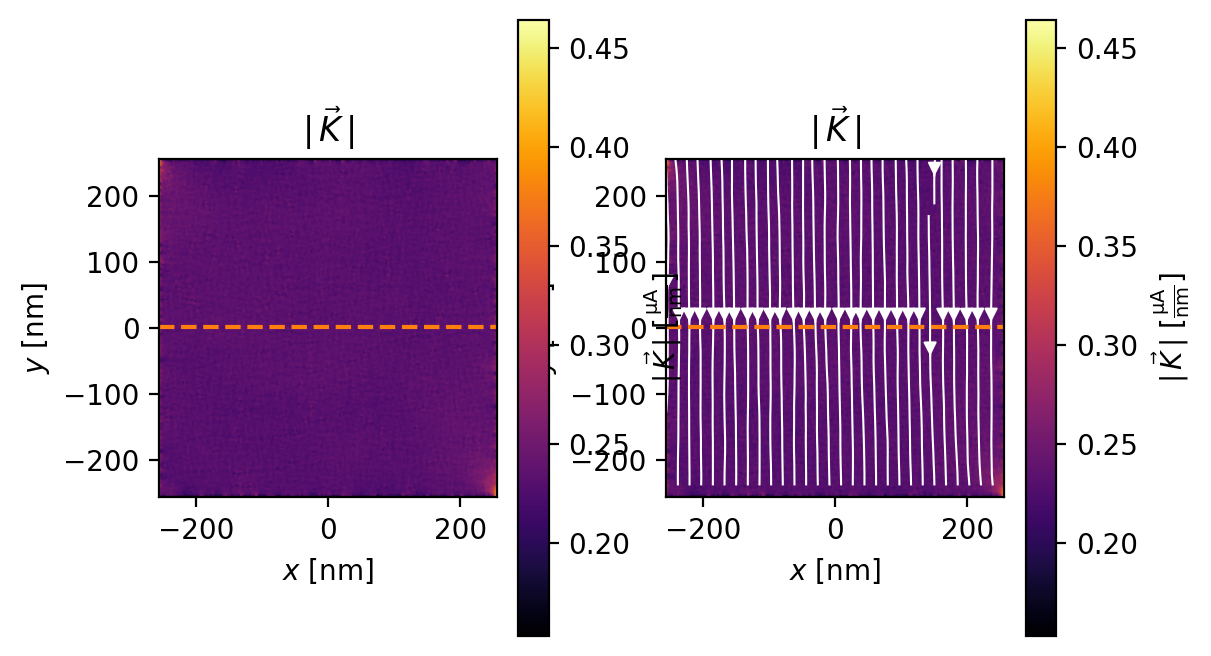

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(6, 4))

_ = zero_field_solution.plot_currents(ax=axes[0], streamplot=False)
_ = zero_field_solution.plot_currents(ax=axes[1])
# Define the coordinates at which to evaluate the sheet current density
x = np.linspace(-total_width / 2, total_width / 2, 401)
y = 2 * np.ones_like(x)
cross_section = np.array([x, y]).T
for ax in axes:
    _ = ax.plot(x, y, "C1--")

In [56]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join("tdgl_results", "weak-link-zero-current.h5"),
    field_units = "mT",
    current_units="uA",
)

RAMP_FIELD = True

if RAMP_FIELD:
    from tdgl.sources import LinearRamp, ConstantField

    # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
    applied_vector_potential = (
        LinearRamp(tmin=0, tmax=100)
        * ConstantField(25, field_units=options.field_units, length_units=device.length_units)
    )
else:
    # If applied_vector_potential is given as a single number,
    # it is interpreted to mean the vector potential associated with a
    # uniform out-of-plane magnetic field with the specified strength.
    # This is simply shorthand for
    # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
    applied_vector_potential = 25

zero_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=applied_vector_potential,
)

Output file already exists. Renaming to tdgl_results\weak-link-zero-current-2.h5.
Simulating: 100%|█████████▉| 200/200 [02:41<00:00,  1.24tau/s ]      


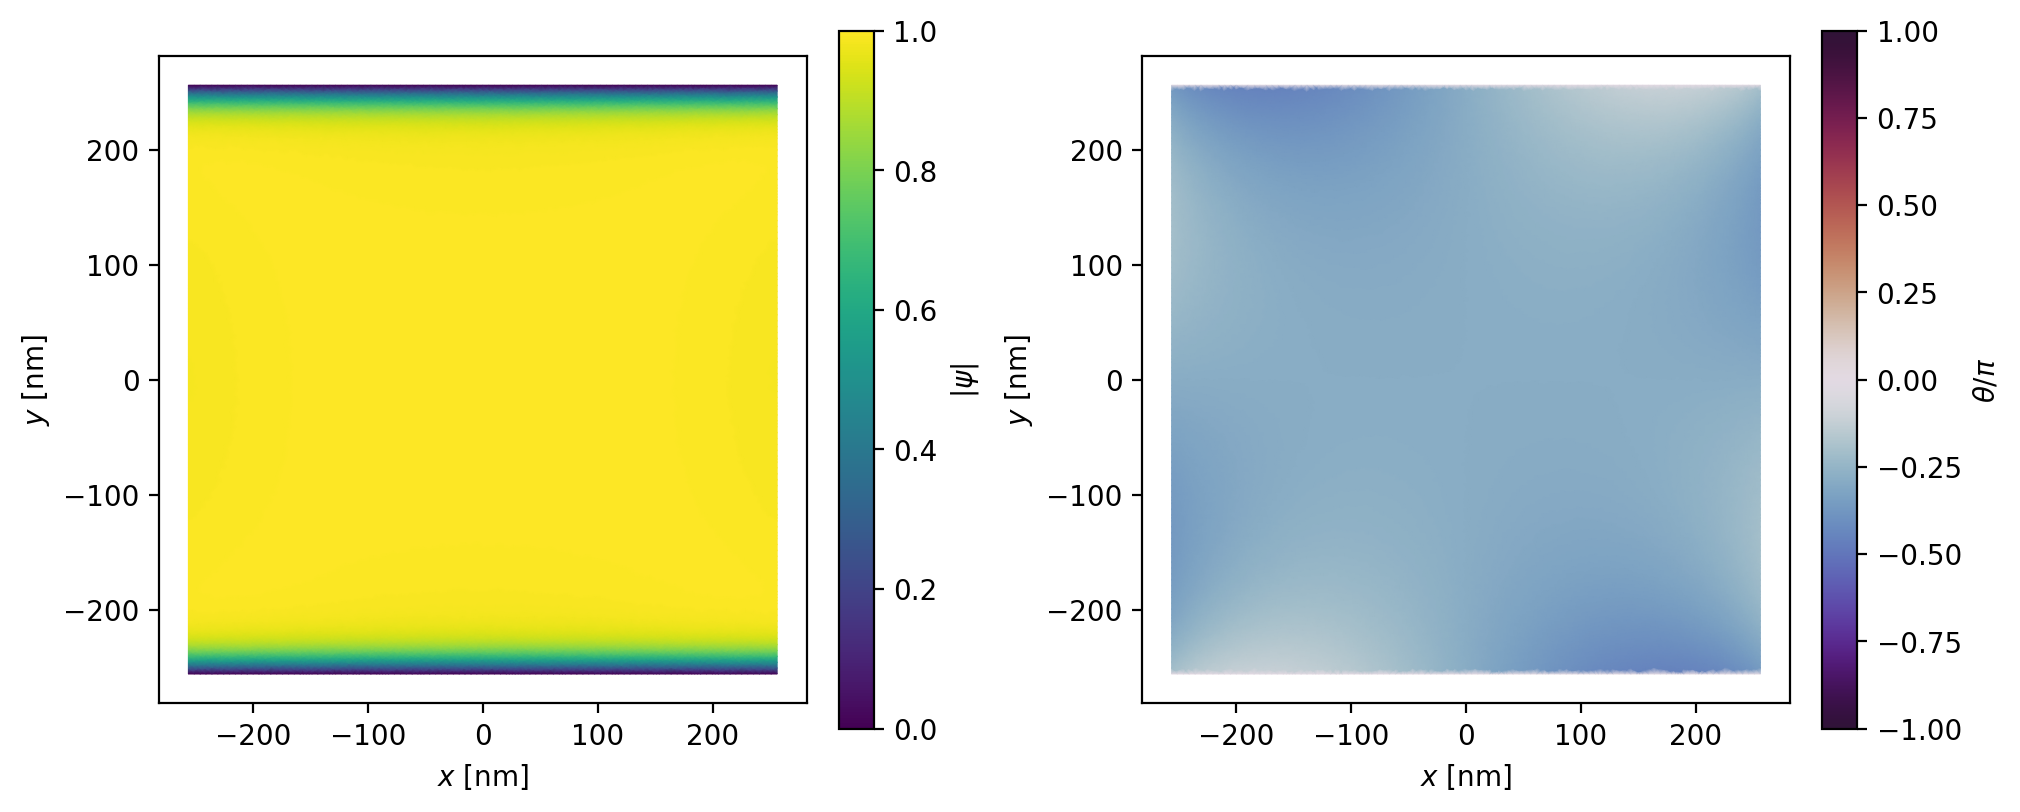

In [57]:
fig, axes = zero_current_solution.plot_order_parameter(figsize=(10, 4))

### Field and Current

In [61]:
options = tdgl.SolverOptions(
    solve_time=200,
    output_file=os.path.join("tdgl_results", "weak-link-zero-current.h5"),
    field_units="mT",
    current_units="uA",
)

RAMP_FIELD = True

if RAMP_FIELD:
    from tdgl.sources import LinearRamp, ConstantField

    # Ramp the applied field from 0 to 0.4 mT between t=0 and t=100, then hold it at 0.4 mT.
    applied_vector_potential = (
        LinearRamp(tmin=0, tmax=100)
        * ConstantField(25, field_units=options.field_units, length_units=device.length_units)
    )
else:
    # If applied_vector_potential is given as a single number,
    # it is interpreted to mean the vector potential associated with a
    # uniform out-of-plane magnetic field with the specified strength.
    # This is simply shorthand for
    # ConstantField(0.4, field_units=options.field_units, length_units=device.length_units).
    applied_vector_potential = 25

field_current_solution = tdgl.solve(
    device,
    options,
    applied_vector_potential=125,
    terminal_currents=dict(source=120, drain=-120),
    # The seed solution will be used as the initial state of the film.
)

Output file already exists. Renaming to tdgl_results\weak-link-zero-current-4.h5.
Simulating: 100%|█████████▉| 200/200 [03:51<00:00,  1.16s/tau ]    


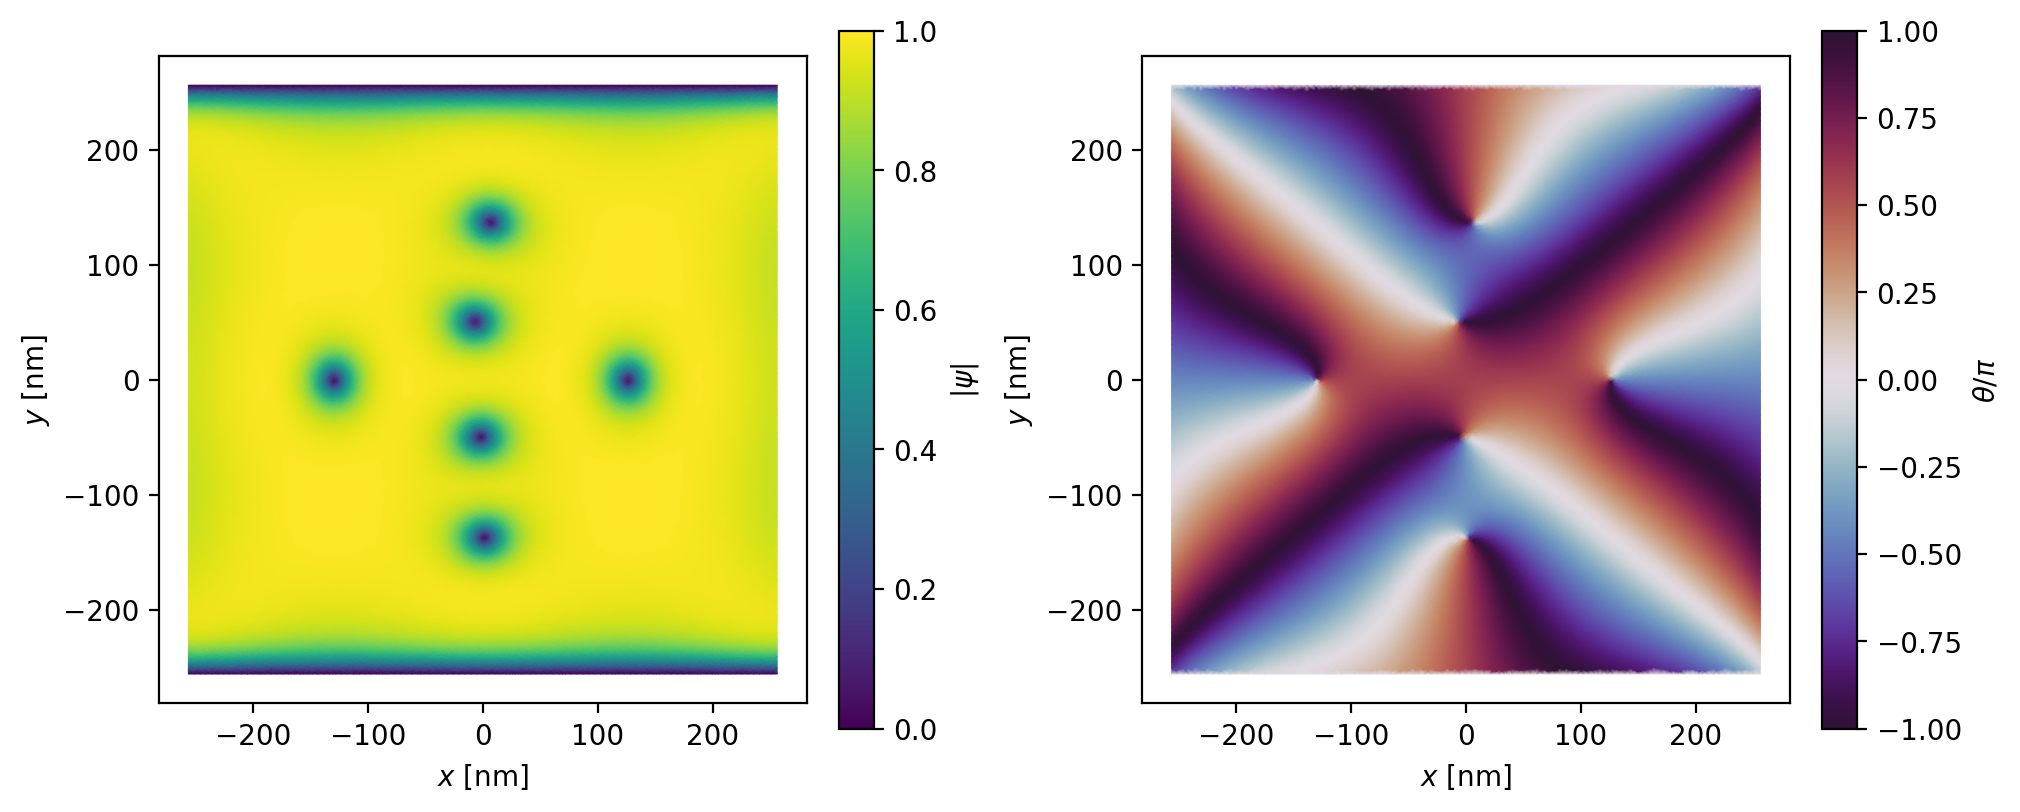

In [62]:
fig, axes   = field_current_solution.plot_order_parameter(figsize=(10, 4))